# Emotion Slope Detection

This notebook will demonstrate the functionality of the emotion slope detection algorithm.

In [34]:
# imports
import os
import sys
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from apps.recommendations.emotion_recognition.processor import SERProcessor
from apps.recommendations.emotion_slope_detection.emotion_slope_detector import EmotionSlopeDetector

In [2]:
# paths
# change as needed
audio_path = "/run/media/chr1s/chr1sdrive1/MuInf/harry-potter/003_039_9781781102404_DESW10646172.mp3"

In [37]:
# consts

# audio processing
AUDIO_SEGMENT_LENGTH_S = 10 
SAMPLE_RATE = 16000

# slope detection
WINDOW_SIZE = 10
SLOPE_DETECTOR_THRESHOLD = 0.005
SLOPE_DETECTOR_GAIN = 50

# plotting
PROBABILITY_THRESHOLD = 0.3
MINIMUM_FREE_SAMPLES = 5

In [4]:
y, sr = librosa.load(audio_path, mono=True, sr=SAMPLE_RATE)
y_segments = librosa.util.frame(y, frame_length=int(sr * AUDIO_SEGMENT_LENGTH_S), hop_length=int(sr * AUDIO_SEGMENT_LENGTH_S)).T
y_segments.shape

(208, 160000)

In [5]:
serprocessor = SERProcessor()
serprocessor.SAMPLE_RATE = sr

emotion_segments = {
    "valence": [],
    "arousal": [],
    "timestamp": [ i * AUDIO_SEGMENT_LENGTH_S for i in range(len(y_segments)) ]
}

for segment in y_segments:
    result = serprocessor._audio_to_speech_emotion(segment)
    emotion_segments["valence"].append(result.valence)
    emotion_segments["arousal"].append(result.arousal)

emotion_segments = pd.DataFrame(emotion_segments)
emotion_segments.set_index("timestamp", inplace=True)

In [38]:
emotion_slope_detector = EmotionSlopeDetector(
    window_size=WINDOW_SIZE,
    threshold=SLOPE_DETECTOR_THRESHOLD,
    gain=SLOPE_DETECTOR_GAIN
)

emotion_segments["slope_probablitly"] = emotion_segments.apply(
    lambda row: emotion_slope_detector.get_slope_probablity(
        row["valence"], row["arousal"]
    ),
    axis=1
)

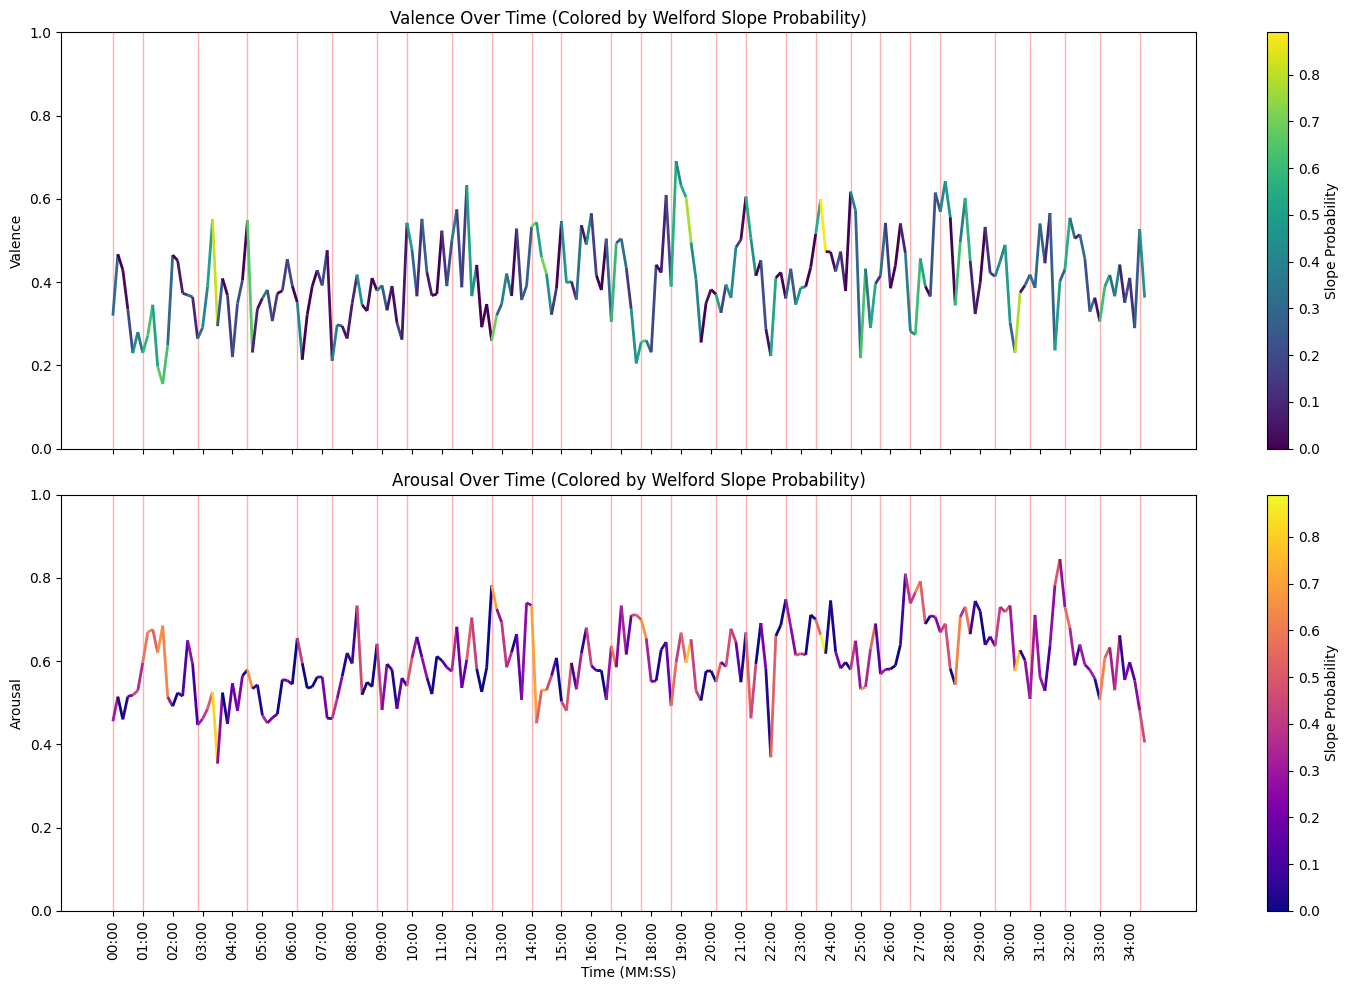

In [39]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Extract data from DataFrame
x = emotion_segments.index  # timestamps in seconds
valence_values = emotion_segments['valence'].values
arousal_values = emotion_segments['arousal'].values
welford_slope_probabilities = emotion_segments['slope_probablitly'].values  # Note: typo in column name preserved

# Convert timestamps to time strings for x-axis labels
time_str = [f"{int(t//60):02d}:{int(t%60):02d}" for t in x]

# --- Valence Plot (Top) ---
# Create segments for valence
points_valence = np.array([x, valence_values]).T.reshape(-1, 1, 2)
segments_valence = np.concatenate([points_valence[:-1], points_valence[1:]], axis=1)

# Create LineCollection for valence - using welford_slope_probabilities for coloring
lc_valence = LineCollection(segments_valence, cmap='viridis', norm=plt.Normalize(min(welford_slope_probabilities), max(welford_slope_probabilities)))
lc_valence.set_array(np.array(welford_slope_probabilities))
lc_valence.set_linewidth(2)
ax1.add_collection(lc_valence)

# Add colorbar for valence
cbar_valence = plt.colorbar(lc_valence, ax=ax1)
cbar_valence.set_label('Slope Probability')

# Configure valence plot
ax1.set_ylabel('Valence')
ax1.set_title('Valence Over Time (Colored by Welford Slope Probability)')

# --- Arousal Plot (Bottom) ---
# Create segments for arousal
points_arousal = np.array([x, arousal_values]).T.reshape(-1, 1, 2)
segments_arousal = np.concatenate([points_arousal[:-1], points_arousal[1:]], axis=1)

# Create LineCollection for arousal - using welford_slope_probabilities for coloring
lc_arousal = LineCollection(segments_arousal, cmap='plasma', norm=plt.Normalize(min(welford_slope_probabilities), max(welford_slope_probabilities)))
lc_arousal.set_array(np.array(welford_slope_probabilities))
lc_arousal.set_linewidth(2)
ax2.add_collection(lc_arousal)

# Add colorbar for arousal
cbar_arousal = plt.colorbar(lc_arousal, ax=ax2)
cbar_arousal.set_label('Slope Probability')

# Configure arousal plot
ax2.set_ylabel('Arousal')
ax2.set_title('Arousal Over Time (Colored by Welford Slope Probability)')

# --- Highlight regions with welford_slope_probabilities >= probability_threshold ---
combined_high = welford_slope_probabilities >= PROBABILITY_THRESHOLD
blocked_high = combined_high.copy()
i = 0
while i < len(blocked_high):
    if blocked_high[i]:  # When we find a True value
        # Block the next minimum_free_samples samples by setting them to False
        end_block = min(i + 1 + MINIMUM_FREE_SAMPLES, len(blocked_high))
        blocked_high[i+1:end_block] = False
        i = end_block  # Jump to the end of the blocked region
    else:
        i += 1  # Move to the next sample

# Find contiguous regions where condition is True
changes = np.diff(blocked_high.astype(int))
starts = np.where(changes == 1)[0] + 1
ends = np.where(changes == -1)[0]

# Handle edge cases
if blocked_high[0]:
    starts = np.insert(starts, 0, 0)
if blocked_high[-1]:
    ends = np.append(ends, len(blocked_high)-1)

# Add horizontal lines for each region
for start, end in zip(starts, ends):
    # Valence plot
    ax1.axvspan(x[start], x[end], color='red', alpha=0.3)
    ax1.axhline(y=valence_values[start], color='red', linestyle='--', alpha=0.5, 
                xmin=start/len(x), xmax=end/len(x))
    
    # Arousal plot
    ax2.axvspan(x[start], x[end], color='red', alpha=0.3)
    ax2.axhline(y=arousal_values[start], color='red', linestyle='--', alpha=0.5, 
                xmin=start/len(x), xmax=end/len(x))

# --- Shared X-axis Configuration ---
n = 6  # Show every 6th label
ax2.set_xticks(x[::n])
ax2.set_xticklabels(time_str[::n], rotation=90)
ax2.set_xlabel('Time (MM:SS)')

plt.tight_layout()
plt.show()